In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

In [3]:
hours_per_day = 24
colors = ["red", [0.8, 0.8, 0.8], "blue"]
position = [0, 0.5, 1]

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", list(zip(position, colors)))


def plot_actogram_double_plotted(sleep_wake_vector, heat_level, dt, simulation_days=14, plot_title=''
                                 ):
    sleep_wake_vector = np.array(sleep_wake_vector)
    heat_level = np.array(heat_level)
    sleep_wake_vector = sleep_wake_vector * 1.0
    sleep_wake_vector[sleep_wake_vector == 1.0] = np.nan
    data = sleep_wake_vector.reshape(
        (simulation_days, int(hours_per_day / dt)))

    custom_cmap.set_bad(color='white')  # Set NaNs to white

    norm = Normalize(vmin=0,
                     vmax=np.max(heat_level))

    amplitude_delta = np.insert(heat_level, 0, 0)
    amplitude_delta = amplitude_delta.reshape(-1, 1)

    scaled_data = amplitude_delta.reshape(
        (simulation_days, int(hours_per_day / dt))) * (1 + data)

    double_plotted_data = np.zeros(
        (simulation_days, int(hours_per_day / dt * 2)))

    # Last day does not have a "next day" to concatenate
    for day in range(simulation_days - 1):
        double_plotted_data[day] = np.concatenate(
            (scaled_data[day], scaled_data[day + 1]))
    double_plotted_data[-1] = np.concatenate(
        (scaled_data[-1], np.nan * np.ones_like(scaled_data[-1])))

    fig, ax = plt.subplots(figsize=(14, 7))

    norm.autoscale_None([np.nan])  # Auto-scale to include NaN

    cax = ax.imshow(double_plotted_data, aspect='auto',
                    cmap=custom_cmap, norm=norm)

    font_size = 40
    tick_font_size = 36

    cbar = fig.colorbar(cax, ax=ax)
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.get_yaxis().labelpad = 25
    cbar.ax.set_ylabel('Light level', rotation=270, fontsize=30)

    # Adjust ticks for 48-hour x-axis
    dt_plot = 4
    x_ticks = np.arange(0, hours_per_day / dt * 2, dt_plot / dt)

    x_tick_labels = [str(int(x % hours_per_day))
                     for x in np.arange(0, hours_per_day * 2, dt_plot)]
    ax.set_xlabel('Local time', fontsize=font_size)
    ax.set_ylabel('Day', fontsize=font_size)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=tick_font_size)

    day_step = 5
    ax.set_yticks(np.arange(0, simulation_days, day_step))
    ax.set_yticklabels(np.arange(0, simulation_days, day_step),
                       fontsize=tick_font_size)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    # plt.savefig(f"outputs/{plot_title}.png", dpi=300)
    # plt.close()
    # plt.show()
    return fig, ax


def alph_forger(light):
    I0 = 9500.0
    p = .6
    a0 = .16
    return a0 * (np.power(light, p) / np.power(I0, p))


def skeldon_model(u, light, current_sleep_state):
    x = u[0]
    xc = u[1]
    n = u[2]
    H = u[3]
    S = current_sleep_state

    effective_light = (1.0 - S) * light
    tx = 24.2
    G = 19.875
    k = .55
    mu = .23
    b = 0.013
    mu_sleep = 17.78
    chi = 45.0

    Bh = G * (1 - n) * alph_forger(effective_light)
    B = Bh * (1 - .4 * x) * (1 - .4 * xc)

    dydt = [0, 0, 0, 0]

    dydt[0] = np.pi / 12.0 * (xc + B)
    dydt[1] = np.pi / 12.0 * (
        mu * (xc - 4.0 * np.power(xc, 3.0) / 3.0) - x * (np.power((24.0 / (.99669 * tx)), 2.0) + k * B))
    dydt[2] = 60.0 * (alph_forger(effective_light) * (1.0 - n) - b * n)
    dydt[3] = (1.0 / chi) * (- H + (1.0 - S) * mu_sleep)

    return np.array(dydt)


def skeldon_rk4_step(ustart: np.ndarray, light_val: float, current_sleep: int, dt: float):
    k1 = skeldon_model(ustart, light_val, current_sleep)
    k2 = skeldon_model(ustart + dt / 2 * k1, light_val,
                       current_sleep)
    k3 = skeldon_model(ustart + dt / 2 * k2, light_val,
                       current_sleep)
    k4 = skeldon_model(ustart + dt * k3, light_val,
                       current_sleep)
    return ustart + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)


def circadian_modulation_of_sleep(x, xc):
    c20 = 0.7896
    alpha21 = -0.3912
    alpha22 = 0.7583
    beta21 = -0.4442
    beta22 = 0.0250
    beta23 = -0.9647

    linear_term = c20 + alpha21 * xc + alpha22 * x
    quadratic_term = beta21 * xc * xc + beta22 * xc * x + beta23 * x * x
    C = linear_term + quadratic_term
    return C


def H_thresholds(x, xc):
    H0 = 13.0
    Delta = 1.0
    ca = 1.72
    C = circadian_modulation_of_sleep(x, xc)
    H_plus = H0 + 0.5 * Delta + ca * C
    H_minus = H0 - 0.5 * Delta + ca * C
    return H_plus, H_minus


def run_model(waking_light_level=3000, pulse_light_level=5000, pulse_at=12, pulse_duration=1, 
              initial_condition=np.array([-0.504, -0.8816, 0.001779, 13.28]),
              initial_sleep_state=0.0, simulation_days=20):
    time_spent_awake = 0

    def wake_dependent_light_intensity(time_spent_awake, pulse_at=pulse_at, pulse_duration=pulse_duration):
        if time_spent_awake < pulse_at:
            return 0
        elif time_spent_awake < pulse_at + pulse_duration:
            return pulse_light_level
        else:
            return 0

    def light_intensity(t):
        t = np.mod(t, 24)
        if 6 <= t < 8:
            return waking_light_level * (t - 6) / 2
        elif 8 <= t < 18:
            return waking_light_level
        elif 18 <= t < 20:
            return waking_light_level * (20 - t) / 2
        else:
            return 0

    dt = 0.001

    count = 0
    num_days = simulation_days
    simulation_duration = hours_per_day * num_days

    u0 = initial_condition
    sol = np.zeros((4, int(simulation_duration / dt)))
    sol[:, 0] = u0
    current_sleep_state = initial_sleep_state

    light_history = []
    sleep_history = [current_sleep_state]

    time_history = [-dt]
    for k in range(int(simulation_duration / dt) - 1):

        light_value = light_intensity(k * dt)
        pulse = wake_dependent_light_intensity(
            time_spent_awake=time_spent_awake)
        light_value = light_value + pulse

        u0 = skeldon_rk4_step(
            u0, light_value, current_sleep=current_sleep_state, dt=dt)

        sol[:, k + 1] = u0
        S = current_sleep_state
        new_sleep_state = current_sleep_state
        H = sol[3, k+1]
        H_plus, H_minus = H_thresholds(sol[0, k+1], sol[1, k+1])

        if S == 0:
            if H >= H_plus:
                new_sleep_state = 1.0
                # print(f"Day {count}: Fell asleep at {np.mod(k*dt, 24)}")
                count = count + 1

        else:
            if H <= H_minus:
                new_sleep_state = 0.0
                # print(f"Day {count}: Woke up at {np.mod(k*dt, 24)}")

        forced_wakeup_by_light = False
        if forced_wakeup_by_light:
            new_sleep_state = 0.0

        if current_sleep_state == 0:
            time_spent_awake = time_spent_awake + dt
        else:
            time_spent_awake = 0
        current_sleep_state = new_sleep_state
        light_history.append((1 - current_sleep_state)
                             * light_value)
        sleep_history.append(current_sleep_state)
        time_history.append(k * dt)

    return sol, sleep_history, light_history, dt, num_days

# Multiple simulations

In [4]:
save_path = 'data/amplitude_simulations/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
baseline_lux_values = np.array([0, 25, 50, 75, 100, 250, 500, 750, 1000], dtype=float)
pulse_at_values = np.linspace(0, 14, 17)

for baseline_lux in baseline_lux_values:
    for pulse_at in pulse_at_values:
        # Equilibration
        eq_sol, eq_sleep_history, eq_light_history, dt, num_days = run_model(waking_light_level=baseline_lux, pulse_at=pulse_at,
                                                                             simulation_days=10)
        initial_condition=eq_sol[:, -1]
        initial_sleep_state = int(eq_sleep_history[-1])
        # Simulation
        sol, sleep_history, light_history, dt, num_days = run_model(waking_light_level=baseline_lux, pulse_at=pulse_at, 
                                                                    initial_condition=initial_condition,
                                                                    initial_sleep_state=initial_sleep_state)
        np.savez(f'{save_path}baseline_{baseline_lux}_pulse_at_{pulse_at}.npz', sol=sol, sleep_history=sleep_history, light_history=light_history, dt=dt, num_days=num_days)
        print(f"Saved baseline_{baseline_lux}_pulse_at_{pulse_at}.npz")

Saved baseline_0.0_pulse_at_0.0.npz
Saved baseline_0.0_pulse_at_0.875.npz
Saved baseline_0.0_pulse_at_1.75.npz
Saved baseline_0.0_pulse_at_2.625.npz
Saved baseline_0.0_pulse_at_3.5.npz
Saved baseline_0.0_pulse_at_4.375.npz
Saved baseline_0.0_pulse_at_5.25.npz
Saved baseline_0.0_pulse_at_6.125.npz
Saved baseline_0.0_pulse_at_7.0.npz
Saved baseline_0.0_pulse_at_7.875.npz
Saved baseline_0.0_pulse_at_8.75.npz
Saved baseline_0.0_pulse_at_9.625.npz
Saved baseline_0.0_pulse_at_10.5.npz
Saved baseline_0.0_pulse_at_11.375.npz
Saved baseline_0.0_pulse_at_12.25.npz
Saved baseline_0.0_pulse_at_13.125.npz
Saved baseline_0.0_pulse_at_14.0.npz
Saved baseline_25.0_pulse_at_0.0.npz
Saved baseline_25.0_pulse_at_0.875.npz
Saved baseline_25.0_pulse_at_1.75.npz
Saved baseline_25.0_pulse_at_2.625.npz
Saved baseline_25.0_pulse_at_3.5.npz
Saved baseline_25.0_pulse_at_4.375.npz
Saved baseline_25.0_pulse_at_5.25.npz
Saved baseline_25.0_pulse_at_6.125.npz
Saved baseline_25.0_pulse_at_7.0.npz
Saved baseline_25.0_

# Single simulation

In [ ]:
sol, sleep_history, light_history, dt, num_days = run_model(waking_light_level=100, pulse_at=14)

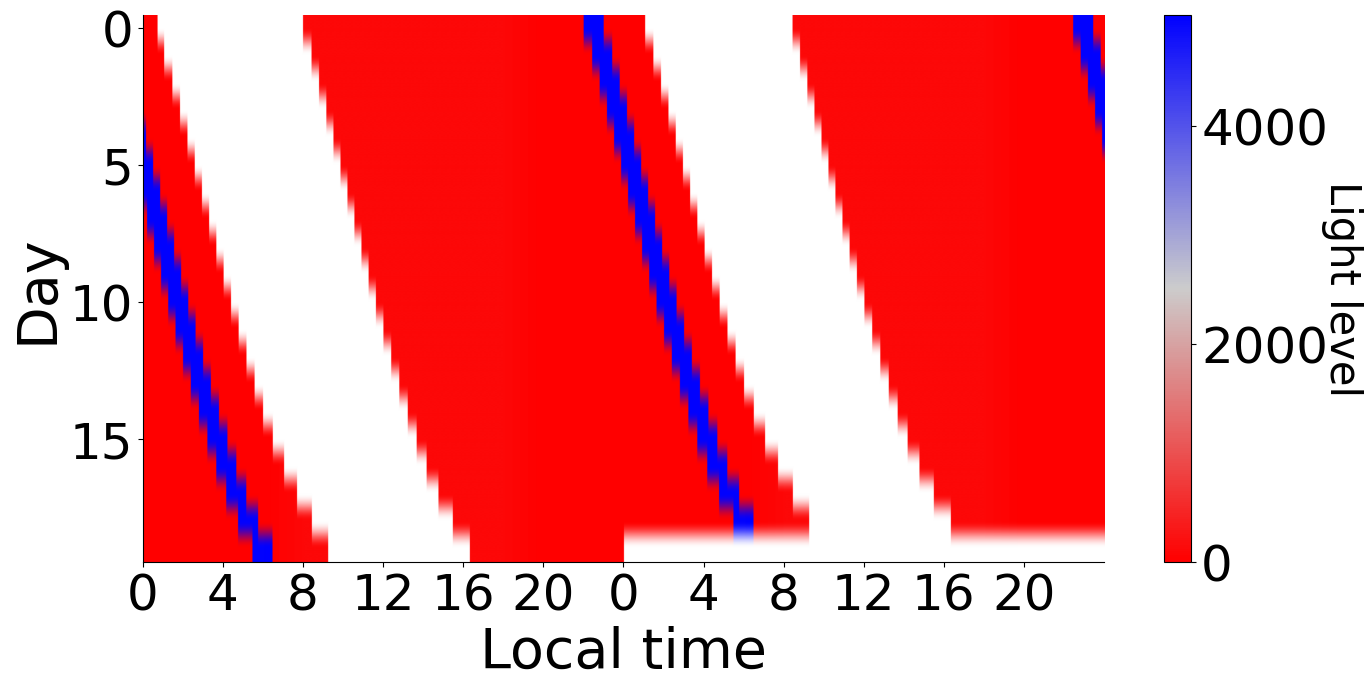

In [21]:
fig, ax = plot_actogram_double_plotted(sleep_history, light_history, dt, simulation_days=num_days, plot_title='skeldon_model')

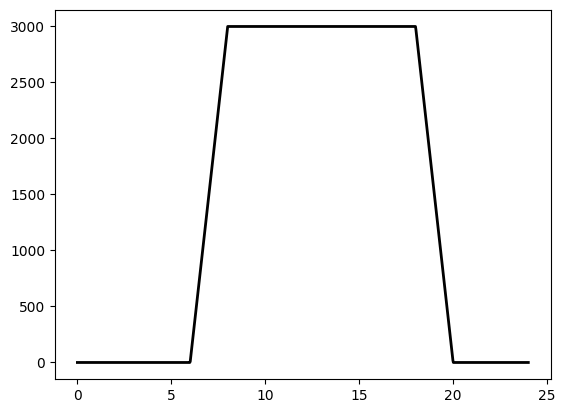

In [6]:
def light_intensity(t, waking_light_level=3000):
    t = np.mod(t, 24)
    if 6 <= t < 8:
        return waking_light_level * (t - 6) / 2
    elif 8 <= t < 18:
        return waking_light_level
    elif 18 <= t < 20:
        return waking_light_level * (20 - t) / 2
    else:
        return 0

t = np.linspace(0, 24, 1000)
light_values = [light_intensity(x) for x in t]
plt.plot(t, light_values, color='black', linewidth=2)
plt.show()